<h1>The BurnMan Tutorial</h1>


## Part 3: Layers and Planets
This file is part of BurnMan - a thermoelastic and thermodynamic toolkit
for the Earth and Planetary Sciences

Copyright (C) 2012 - 2021 by the BurnMan team,
released under the GNU GPL v2 or later.

### Introduction

This ipython notebook is the third in a series designed to introduce new users to the code structure and functionalities present in BurnMan.

<b>Demonstrates</b>

1. burnman.Layer
2. burnman.Planet


Everything in BurnMan and in this tutorial is defined in SI units. 

### Building a planet

Planets are, to a good first approximation, layered like an onion. They typically have a core, a mantle and a crust, stratified according to density. Because temperature and pressure are both strongly correlated with depth, major phase transitions are (again, to first order) reasonably treated as being continuous and horizontal.

On Earth, these approximations have led to 1D models of properties, such as PREM (Dziewonski and Anderson, 1981) and AK135 (Kennett, Engdahl and Buland, 1995). These models can be used as a starting point for studies investigating the possible composition and temperature of Earth's deep interior.

On other planets, we do not yet have data anywhere near as good as for Earth, and so interior structure is less well-known. What we do have is gravity at the surface, mass of the planet, and moment of inertia. So the question is then, what might those things tell us about interior mineralogy?

BurnMan includes Layer and Planet classes to help investigate these questions.

### The Layer class

The Layer class in BurnMan is designed to represent a spherical shell of a planet. That shell is made of a BurnMan Material object. The user can specify how the pressure and temperature evolve within the Layer.

The following code block creates a lower_mantle layer of mg_bridgmanite and periclase in 80:20 molar proportions, and assigns an adiabatic profile with a temperature of 1900 K at the top of the layer. The pressure is set to be self-consistent; i.e. the gravity and pressure are adjusted to ensure that pressure is hydrostatic.

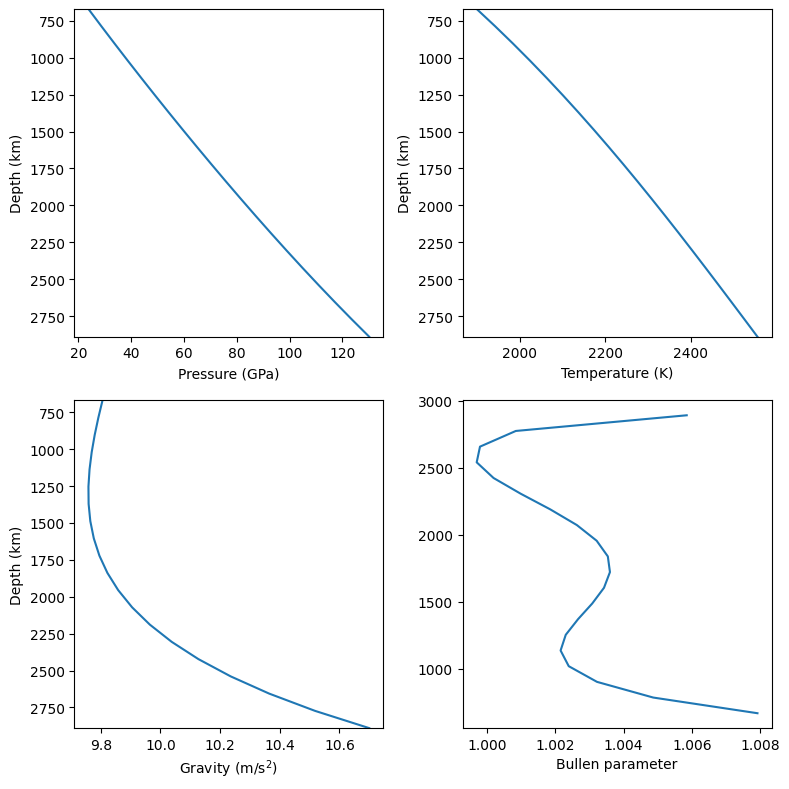

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import burnman
from burnman import Mineral, PerplexMaterial, Composite, Layer, Planet
from burnman import minerals


depths = np.linspace(2890e3, 670e3, 20)
rock = Composite([minerals.SLB_2011.mg_bridgmanite(),
                  minerals.SLB_2011.periclase()],
                 [0.8, 0.2])

lower_mantle = Layer(name='Lower Mantle', radii=6371.e3-depths)
lower_mantle.set_material(rock)    
lower_mantle.set_temperature_mode(temperature_mode='adiabatic',
                                  temperature_top=1900.)
lower_mantle.set_pressure_mode(pressure_mode='self-consistent',
                               pressure_top=23.8e9,
                               gravity_bottom=10.7)

# The "make" method does the calculations to make the pressure and gravity self-consistent.
lower_mantle.make()

fig = plt.figure(figsize=(8, 8))
ax = [fig.add_subplot(2, 2, i) for i in range(1, 5)]
ax[0].plot(lower_mantle.pressure/1.e9, 6371.-lower_mantle.radii/1.e3)
ax[1].plot(lower_mantle.temperature, 6371.-lower_mantle.radii/1.e3)
ax[2].plot(lower_mantle.gravity, 6371.-lower_mantle.radii/1.e3)
ax[3].plot(lower_mantle.bullen, 6371.-lower_mantle.radii/1.e3)
for i in range(3):
    ax[i].set_ylim(6371.-lower_mantle.radii[0]/1.e3,
                   6371.-lower_mantle.radii[-1]/1.e3)
    ax[i].set_ylabel('Depth (km)')

ax[0].set_xlabel('Pressure (GPa)')
ax[1].set_xlabel('Temperature (K)')
ax[2].set_xlabel('Gravity (m/s$^2$)')
ax[3].set_xlabel('Bullen parameter')

fig.set_tight_layout(True)

### The Planet class

In a 1D Planet, the pressure, gravity, temperature and temperature gradient at the interfaces between layers must be continuous. In BurnMan, it is possible to collect layers together into a Planet, and have the "make" method of Planet work out how to ensure continuity (at least for pressure, gravity and temperature; for the sake of flexibility, temperature gradient is allowed to be discontinuous).

In the following example, we build Planet Zog, a planet similar to Earth but a little simpler in mineralogical makeup. First, we create an adiabatic inner core. The inner core probably isn't adiabatic, but this is largely unimportant for the innermost layer.

In [3]:
from burnman import Composition
from burnman.tools.chemistry import formula_mass

# Compositions from midpoints of Hirose et al. (2021), ignoring carbon and hydrogen
inner_core_composition = Composition({'Fe': 94.4, 'Ni': 5., 'Si': 0.55, 'O': 0.05}, 'weight')
outer_core_composition = Composition({'Fe': 90., 'Ni': 5., 'Si': 2., 'O': 3.}, 'weight')


for c in [inner_core_composition, outer_core_composition]:
    c.renormalize('atomic', 'total', 1.)

inner_core_elemental_composition = dict(inner_core_composition.atomic_composition)
outer_core_elemental_composition = dict(outer_core_composition.atomic_composition)
inner_core_molar_mass = formula_mass(inner_core_elemental_composition)
outer_core_molar_mass = formula_mass(outer_core_elemental_composition)

In [4]:
icb_radius = 1220.e3
inner_core = Layer('inner core', radii=np.linspace(0., icb_radius, 21))

hcp_iron = minerals.SE_2015.hcp_iron()
params = hcp_iron.params

params['name'] = 'modified solid iron'
params['formula'] = inner_core_elemental_composition
params['molar_mass'] = inner_core_molar_mass
delta_V = 2.0e-7

inner_core_material = Mineral(params=params,
                              property_modifiers=[['linear',
                                                   {'delta_E': 0.,
                                                    'delta_S': 0.,
                                                    'delta_V': delta_V}]])

# check that the new inner core material does what we expect:
hcp_iron.set_state(200.e9, 4000.)
inner_core_material.set_state(200.e9, 4000.)
assert np.abs(delta_V - (inner_core_material.V - hcp_iron.V)) < 1.e-12

inner_core.set_material(inner_core_material)

inner_core.set_temperature_mode('adiabatic')

Now, we create an adiabatic outer core.

In [5]:
cmb_radius = 3480.e3
outer_core = Layer('outer core', radii=np.linspace(icb_radius, cmb_radius, 21))

liq_iron = minerals.SE_2015.liquid_iron()
params = liq_iron.params

params['name'] = 'modified liquid iron'
params['formula'] = outer_core_elemental_composition
params['molar_mass'] = outer_core_molar_mass
delta_V = -2.3e-7
outer_core_material = Mineral(params=params,
                              property_modifiers=[['linear',
                                                   {'delta_E': 0.,
                                                    'delta_S': 0.,
                                                    'delta_V': delta_V}]])

# check that the new inner core material does what we expect:
liq_iron.set_state(200.e9, 4000.)
outer_core_material.set_state(200.e9, 4000.)
assert np.abs(delta_V - (outer_core_material.V - liq_iron.V)) < 1.e-12

outer_core.set_material(outer_core_material)

outer_core.set_temperature_mode('adiabatic')

Now, we assume that there is a single mantle layer that is convecting. We import a PerpleX input table that contains the material properties of pyrolite for this layer. We'll use this for the convecting mantle layer. We apply a perturbed adiabatic temperature profile.

In [7]:
from burnman import BoundaryLayerPerturbation

lab_radius = 6171.e3 # 200 km thick lithosphere
lab_temperature = 1550.

convecting_mantle_radii = np.linspace(cmb_radius, lab_radius, 101)
convecting_mantle = Layer('convecting mantle', radii=convecting_mantle_radii)

# Import a low resolution PerpleX data table.
fname = '../tutorial/data/pyrolite_perplex_table_lo_res.dat'
pyrolite = minerals.Matas_etal_2007.mg_perovskite()
convecting_mantle.set_material(pyrolite)

# Here we add a thermal boundary layer perturbation, assuming that the
# lower mantle has a Rayleigh number of 1.e7, and that the basal thermal
# boundary layer has a temperature jump of 840 K and the top
# boundary layer has a temperature jump of 60 K.
tbl_perturbation = BoundaryLayerPerturbation(radius_bottom=cmb_radius,
                                             radius_top=lab_radius,
                                             rayleigh_number=1.e7,
                                             temperature_change=900.,
                                             boundary_layer_ratio=60./900.)

# Onto this perturbation, we add a linear superadiabaticity term according
# to Anderson (he settled on 200 K over the lower mantle)
dT_superadiabatic = 300.*(convecting_mantle_radii - convecting_mantle_radii[-1])/(convecting_mantle_radii[0] - convecting_mantle_radii[-1])

convecting_mantle_tbl = (tbl_perturbation.temperature(convecting_mantle_radii)
                         + dT_superadiabatic)

convecting_mantle.set_temperature_mode('perturbed-adiabatic',
                                       temperatures=convecting_mantle_tbl)

And the lithosphere has a user-defined conductive gradient.

In [8]:
moho_radius = 6341.e3
moho_temperature = 620.

dunite = minerals.SLB_2011.mg_fe_olivine(molar_fractions=[0.92, 0.08])
lithospheric_mantle = Layer('lithospheric mantle',
                            radii=np.linspace(lab_radius, moho_radius, 31))
lithospheric_mantle.set_material(dunite)
lithospheric_mantle.set_temperature_mode('user-defined',
                                         np.linspace(lab_temperature,
                                                     moho_temperature, 31))

Finally, we assume the crust has the density of andesine ~ 40% anorthite

In [9]:
planet_radius = 6371.e3
surface_temperature = 300.
andesine = minerals.SLB_2011.plagioclase(molar_fractions=[0.4, 0.6])
crust = Layer('crust', radii=np.linspace(moho_radius, planet_radius, 11))
crust.set_material(andesine)
crust.set_temperature_mode('user-defined',
                           np.linspace(moho_temperature,
                                       surface_temperature, 11))

Everything is ready! Let's make our planet from its consistuent layers.

In [10]:
planet_zog = Planet('Planet Zog',
                    [inner_core, outer_core,
                     convecting_mantle, lithospheric_mantle,
                     crust], verbose=True)
planet_zog.make()

Iteration 1 maximum relative pressure error: 9.6e-01
Iteration 2 maximum relative pressure error: 4.5e-01
Iteration 3 maximum relative pressure error: 1.8e-01
Iteration 4 maximum relative pressure error: 6.6e-02
Iteration 5 maximum relative pressure error: 2.4e-02
Iteration 6 maximum relative pressure error: 8.7e-03
Iteration 7 maximum relative pressure error: 3.1e-03
Iteration 8 maximum relative pressure error: 1.1e-03
Iteration 9 maximum relative pressure error: 4.1e-04
Iteration 10 maximum relative pressure error: 1.5e-04
Iteration 11 maximum relative pressure error: 5.3e-05
Iteration 12 maximum relative pressure error: 1.9e-05
Iteration 13 maximum relative pressure error: 6.9e-06


Now we output the mass of the planet and moment of inertia and the mass of the individual layers:

In [11]:
earth_mass = 5.972e24
earth_moment_of_inertia_factor = 0.3307

print(f'mass = {planet_zog.mass:.3e} (Earth = {earth_mass:.3e})')
print(f'moment of inertia factor= {planet_zog.moment_of_inertia_factor:.4f} '
      f'(Earth = {earth_moment_of_inertia_factor:.4f})')

print('Layer mass fractions:')
for layer in planet_zog.layers:
    print(f'{layer.name}: {layer.mass / planet_zog.mass:.3f}')

mass = 6.136e+24 (Earth = 5.972e+24)
moment of inertia factor= 0.3350 (Earth = 0.3307)
Layer mass fractions:
inner core: 0.016
outer core: 0.304
convecting mantle: 0.627
lithospheric mantle: 0.046
crust: 0.007


BurnMan contains some utility functions that output data in a format readable by seismic codes such as Axisem and Mineos.

Writing axisem_zog_silicates.txt ...


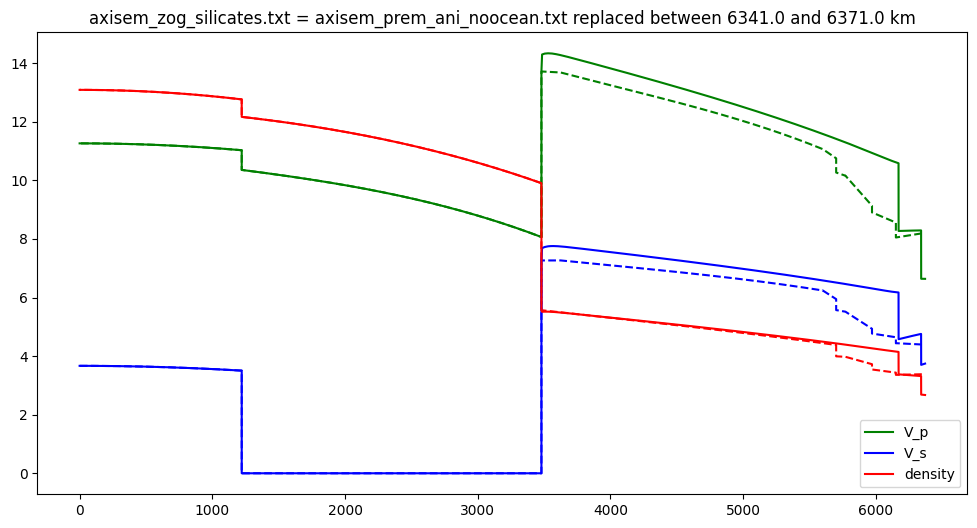

Writing mineos_zog_silicates.txt ...


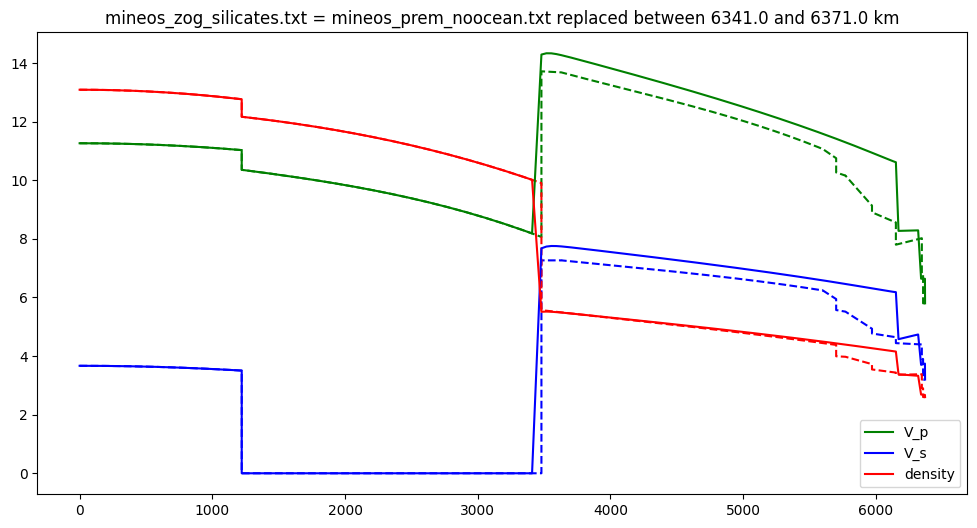

In [12]:
from burnman.tools.output_seismo import write_axisem_input
from burnman.tools.output_seismo import write_mineos_input

write_axisem_input([convecting_mantle, lithospheric_mantle, crust], modelname='zog_silicates', plotting=True)
write_mineos_input([convecting_mantle, lithospheric_mantle, crust], modelname='zog_silicates', plotting=True)

# Now we delete the newly-created files. If you want them, comment out these lines.
import os
os.remove('axisem_zog_silicates.txt')
os.remove('mineos_zog_silicates.txt')

Let's compare the properties of this planet to PREM

In [13]:
import warnings
prem = burnman.seismic.PREM()
premdepth = prem.internal_depth_list()
premradii = 6371.e3 - premdepth

with warnings.catch_warnings(record=True) as w:
    eval = prem.evaluate(['density', 'pressure', 'gravity', 'v_s', 'v_p'])
    premdensity, prempressure, premgravity, premvs, premvp = eval
    print(w[-1].message)

Gravity is not given in PREM and is now being computed. This will only work when density is defined for the entire planet. Use at your own risk.


Also create the Anzellini et al. (2013) geotherm:

In [14]:
from scipy.interpolate import interp1d
d = np.loadtxt('../tutorial/data/Anzellini_2013_geotherm.dat')
Anz_interp = interp1d(d[:,0]*1.e9, d[:,1])

FileNotFoundError: ../tutorial/data/Anzellini_2013_geotherm.dat not found.

Finally, plot the 1D structure of the planet

NameError: name 'Anz_interp' is not defined

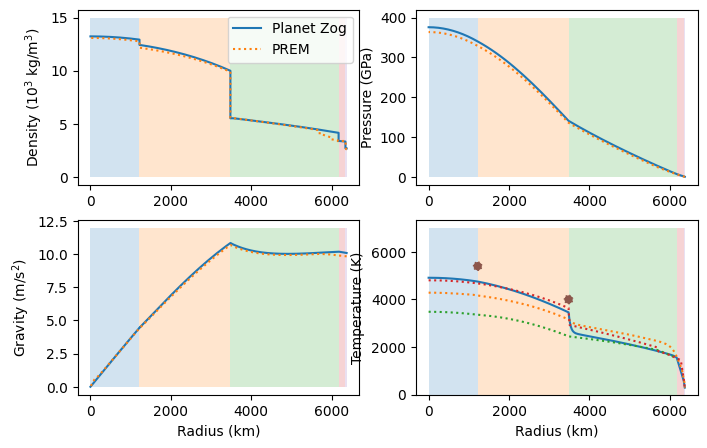

: 

In [15]:
fig = plt.figure(figsize=(8, 5))
ax = [fig.add_subplot(2, 2, i) for i in range(1, 5)]


bounds = np.array([[layer.radii[0]/1.e3, layer.radii[-1]/1.e3]
                   for layer in planet_zog.layers])
maxy = [15, 400, 12, 7000]
for bound in bounds:
    for i in range(4):
        ax[i].fill_betweenx([0., maxy[i]],
                            [bound[0], bound[0]],
                            [bound[1], bound[1]], alpha=0.2)

ax[0].plot(planet_zog.radii / 1.e3, planet_zog.density / 1.e3,
           label=planet_zog.name)
ax[0].plot(premradii / 1.e3, premdensity / 1.e3, linestyle=':', label='PREM')
ax[0].set_ylabel('Density ($10^3$ kg/m$^3$)')
ax[0].legend()

# Make a subplot showing the calculated pressure profile
ax[1].plot(planet_zog.radii / 1.e3, planet_zog.pressure / 1.e9)
ax[1].plot(premradii / 1.e3, prempressure / 1.e9, linestyle=':')
ax[1].set_ylabel('Pressure (GPa)')

# Make a subplot showing the calculated gravity profile
ax[2].plot(planet_zog.radii / 1.e3, planet_zog.gravity)
ax[2].plot(premradii / 1.e3, premgravity, linestyle=':')
ax[2].set_ylabel('Gravity (m/s$^2)$')
ax[2].set_xlabel('Radius (km)')

# Make a subplot showing the calculated temperature profile
ax[3].plot(planet_zog.radii / 1.e3, planet_zog.temperature)
ax[3].set_ylabel('Temperature (K)')
ax[3].set_xlabel('Radius (km)')
ax[3].set_ylim(0.,)

# Finally, let's overlay some geotherms onto our model
# geotherm
labels = ['Stacey (1977)',
          'Brown and Shankland (1981)',
          'Anderson (1982)',
          'Alfe et al. (2007)',
          'Anzellini et al. (2013)']

short_labels = ['S1977',
                'BS1981',
                'A1982',
                'A2007',
                'A2013']

ax[3].plot(planet_zog.radii / 1.e3,
burnman.geotherm.stacey_continental(planet_zog.depth),
linestyle=':', label=short_labels[0])
mask = planet_zog.depth > 269999.
ax[3].plot(planet_zog.radii[mask] / 1.e3,
           burnman.geotherm.brown_shankland(planet_zog.depth[mask]),
           linestyle=':', label=short_labels[1])
ax[3].plot(planet_zog.radii / 1.e3,
           burnman.geotherm.anderson(planet_zog.depth),
           linestyle=':', label=short_labels[2])

ax[3].scatter([planet_zog.layers[0].radii[-1] / 1.e3,
               planet_zog.layers[1].radii[-1] / 1.e3],
              [5400., 4000.],
              linestyle=':', label=short_labels[3])

mask = planet_zog.pressure < 330.e9
temperatures = Anz_interp(planet_zog.pressure[mask])
ax[3].plot(planet_zog.radii[mask] / 1.e3, temperatures,
           linestyle=':', label=short_labels[4])

ax[3].legend()

for i in range(2):
    ax[i].set_xticklabels([])
for i in range(4):
    ax[i].set_xlim(0., max(planet_zog.radii) / 1.e3)
    ax[i].set_ylim(0., maxy[i])

fig.set_tight_layout(True)
plt.show()

And that's it! Next time, we'll look at some of BurnMan's fitting routines.